<a href="https://colab.research.google.com/github/HarrisonSantiago/sparsecoding/blob/main/examples/sparse_coding_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a minimal example to show how you can use the sparse coding repo in a colab environment

In [1]:
!git clone https://github.com/rctn/sparsecoding.git
%cd /content/sparsecoding
import os
os.environ['PYTHONPATH'] = f"/content/energy-based-learning:{os.environ.get('PYTHONPATH', '')}"

Cloning into 'sparsecoding'...
remote: Enumerating objects: 1364, done.
remote: Counting objects: 100% (579/579), done.
remote: Compressing objects: 100% (308/308), done.
remote: Total 1364 (delta 298), reused 413 (delta 265), pack-reused 785 (from 1)
Receiving objects: 100% (1364/1364), 26.37 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (743/743), done.
/content/sparsecoding


In [2]:
import os
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from IPython.display import clear_output

from sparsecoding.data.transforms.patch import sample_random_patches
from sparsecoding import inference, models, visualization
from tutorials.vanilla.src import utils

import urllib.request


#Download and Visualize Data

In [4]:
mat_url = "https://rctn.org/bruno/sparsenet/IMAGES.mat"
save_path = "/content/sparsecoding/IMAGES.mat"
urllib.request.urlretrieve(mat_url, save_path)
print(f"File successfully downloaded to {save_path}")

File successfully downloaded to /content/sparsecoding/IMAGES.mat


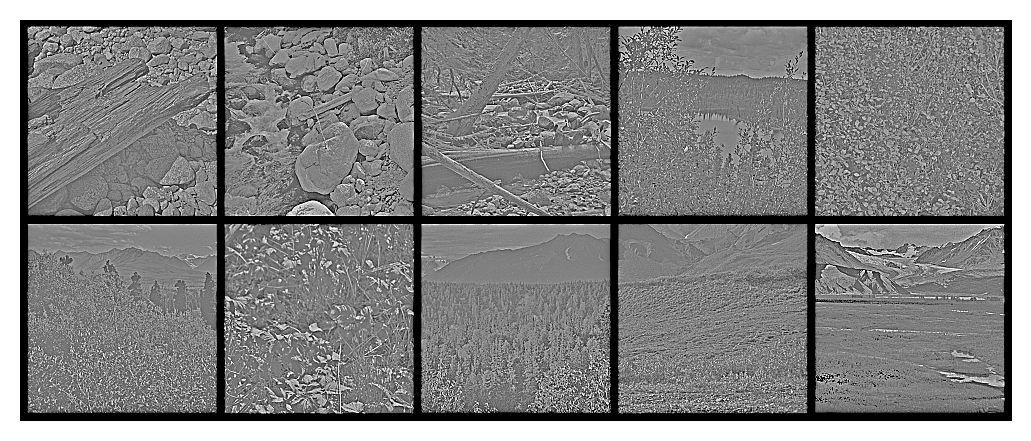

In [5]:
imgs = utils.load_data(save_path)
utils.show_imgs(imgs)

In [6]:
images = loadmat(save_path)['IMAGES']
images = torch.tensor(images).permute([2,0,1]).unsqueeze(1)
images = images.type(torch.float32)
print(images.shape)

torch.Size([10, 1, 512, 512])


#Visualize Patches

In [7]:
n_patches = 100
patch_size = 16
patches = sample_random_patches(image=images, patch_size=patch_size, num_patches=n_patches)
data = patches.reshape([n_patches, -1])

n_samples, n_features = data.shape

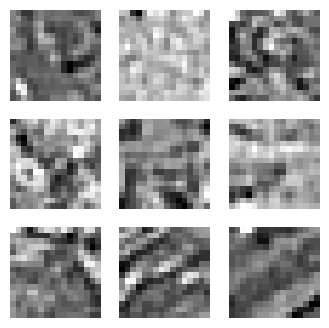

In [8]:
figure = plt.figure(figsize=(4,4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img = (data[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().reshape([patch_size, patch_size]), cmap="gray")
plt.show()

#Sparse Coding via Dictionary Learning

In [9]:
### DEFINE MODEL
lca = inference.LCA(coeff_lr=1e-3,threshold=0.1,n_iter=300)
sc = models.SparseCoding(inference_method=lca,n_basis=n_features,n_features=n_features,dictionary_lr=1e-1)

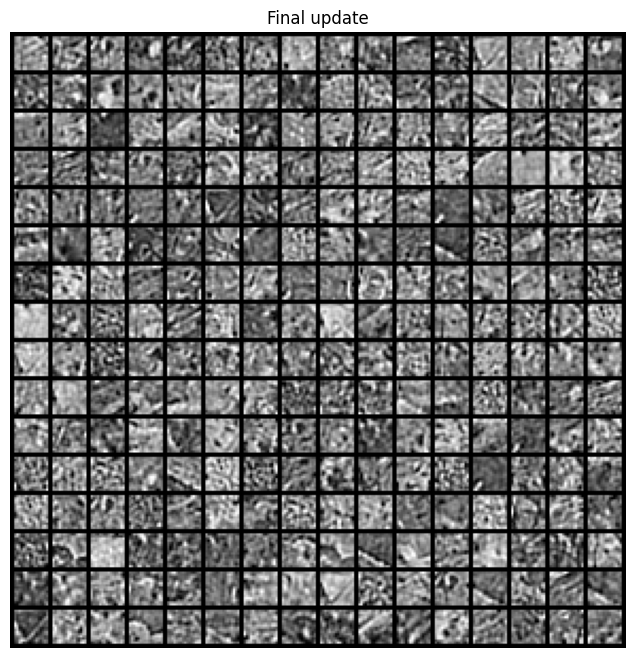

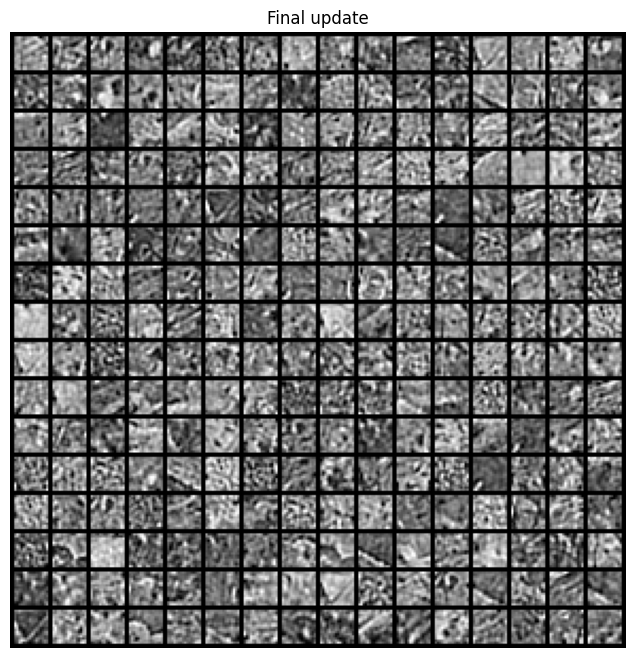

In [12]:
n_epoch = 25
montage_update_rate = 5
n_updates = n_epoch // montage_update_rate

# Plot Updates
nrow = 16
fig, ax = visualization.plot_dictionary(sc.dictionary, nrow=nrow)

losses = []

for i in range(n_epoch):
    # learn dictionary
    loss = sc.learn_dictionary(dataset=data, n_epoch=1, batch_size=500)
    losses.append(loss)

    # update montage
    if i % montage_update_rate == 0:
        # Clear previous output
        clear_output(wait=True)
        current_update = i // montage_update_rate
        fig, ax = visualization.plot_dictionary(sc.dictionary, fig=fig, ax=ax,
                                title=f'update: {current_update} of {n_updates}',
                                nrow=nrow)
        display(fig)
        time.sleep(3) #You can lower the time, just may skip some plots


clear_output(wait=True)
fig, ax = visualization.plot_dictionary(sc.dictionary, fig=fig, ax=ax,
                         title=f'Final update',
                         nrow=nrow)
display(fig)


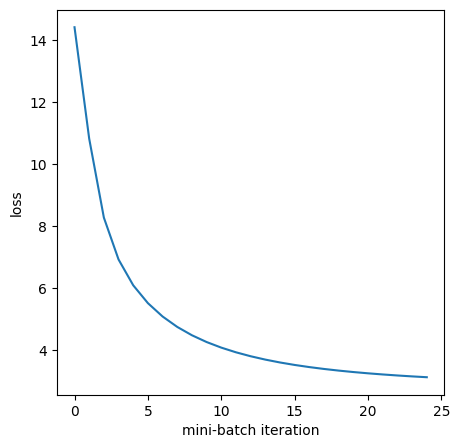

In [11]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(losses)
ax.set_xlabel('mini-batch iteration')
ax.set_ylabel('loss')
plt.show()